In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
# Define hyperparameters
symbol = 'AAPL'
start_date = '2010-01-01'
end_date = '2023-09-22'
seq_length = 5 # days picked
input_size = 3 # one value per row (closing price) # updated to 2 for the volume and 3 rsi
hidden_size = 64
num_layers = 2 # 2 layers of the LSTM
output_size = 1
num_epochs = 150
learning_rate = 0.001

**1) Data loading, Pre processing and RSI functions**

In [3]:
# Load Historical stock data
def load_stock_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

In [4]:
data = load_stock_data(symbol, start_date, end_date)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487533,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498750,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395380,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383558,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425995,447610800
...,...,...,...,...,...,...
2023-09-15,176.479996,176.500000,173.820007,175.009995,175.009995,109205100
2023-09-18,176.479996,179.380005,176.169998,177.970001,177.970001,67257600
2023-09-19,177.520004,179.630005,177.130005,179.070007,179.070007,51826900


In [5]:
# RSI

# Calculate daily price changes
data['Price Change'] = data['Close'].diff()

# Calculate the average gain and average loss over a 14-day period
gain = data['Price Change'].where(data['Price Change'] > 0, 0)
loss = -data['Price Change'].where(data['Price Change'] < 0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Calculate the Relative Strength (RS)
rs = avg_gain / avg_loss

# Calculate the RSI
rsi = 100 - (100 / (1 + rs))

# Add RSI to the DataFrame
data['RSI'] = rsi

In [6]:
# NaN Check for the RSI
# NaN fill with 0
data['RSI'].fillna(0, inplace=True)
data['RSI'].isna().sum()

0

In [7]:
data

,Open,High,Low,Close,Adj Close,Volume,Price Change,RSI
Date,,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487533,493729600,NaN,0.000000
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498750,601904800,0.013215,0.000000
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395380,552160000,-0.121786,0.000000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383558,477131200,-0.013929,0.000000
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425995,447610800,0.050000,0.000000
...,...,...,...,...,...,...,...,...
2023-09-15,176.479996,176.500000,173.820007,175.009995,175.009995,109205100,-0.730011,44.451286
2023-09-18,176.479996,179.380005,176.169998,177.970001,177.970001,67257600,2.960007,46.717917
2023-09-19,177.520004,179.630005,177.130005,179.070007,179.070007,51826900,1.100006,41.852236


In [8]:
# Get the last day
last_date = data.index[-1]
print(f'The last date is: {last_date}')

The last date is: 2023-09-21 00:00:00


In [9]:
# Function to get only the week day (not weekend)
def get_next_weekday_date(date):
    while date.weekday() >= 5:  # Check if the date is Saturday (5) or Sunday (6)
        date += datetime.timedelta(days=1)  # Move to the next day
    return date

In [10]:
# Get the next day
tomorrow_date = get_next_weekday_date(last_date + datetime.timedelta(days=1))
print(f'The next date is: {tomorrow_date}')

The next date is: 2023-09-22 00:00:00


In [11]:
# Preprocess the data
def preprocess_data(data):
    # Extract the features
    prices = data['Close'].values.astype(float)
    volume = data['Volume'].values.astype(float)
    rsi = data['RSI'].values.astype(float)
    print(f'Before scaling prices: \n {prices} \n \n')
    print(f'Before scaling volume: \n {volume} \n \n')
    print(f'Before scaling rsi: \n {rsi} \n \n')
    # Normalize the data using Min-Max scaling
    price_scaler = MinMaxScaler()
    vol_scaler = MinMaxScaler()
    rsi_scaler = MinMaxScaler()
    prices = price_scaler.fit_transform(prices.reshape(-1, 1))
    volume = vol_scaler.fit_transform(volume.reshape(-1, 1))
    rsi = rsi_scaler.fit_transform(rsi.reshape(-1, 1))

    return prices, volume, rsi, price_scaler, vol_scaler, rsi_scaler

In [12]:
# Get the sclaed values for the selected features
prices, volume, rsi, price_scaler, vol_scaler, rsi_scaler = preprocess_data(data)
print(f'\nPrice scaled values\n')
print(prices)
print(f'\nVolume scaled values\n')
print(volume)
print(f'\nRSI scaled values\n')
print(rsi)

Before scaling prices: 
 [  7.64321423   7.65642881   7.53464317 ... 179.07000732 175.49000549
 173.92999268] 
 

Before scaling volume: 
 [4.937296e+08 6.019048e+08 5.521600e+08 ... 5.182690e+07 5.843620e+07
 6.304790e+07] 
 

Before scaling rsi: 
 [ 0.          0.          0.         ... 41.85223554 30.41240484
 28.47438666] 
 


Price scaled values

[[0.00413672]
 [0.00420642]
 [0.00356406]
 ...
 [0.90832907]
 [0.88944631]
 [0.88121801]]

Volume scaled values

[[0.24993861]
 [0.30842624]
 [0.28153047]
 ...
 [0.01101285]
 [0.01458633]
 [0.01707976]]

RSI scaled values

[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.42930839]
 [0.31196184]
 [0.2920822 ]]


In [13]:
# Create sequences for the Model
def create_sequences(data_price, data_vol, data_rsi, seq_length):
    sequences = []
    target = []
    for i in range(len(data_price) - seq_length):
        seq = (data_price[i:i+seq_length], data_vol[i:i+seq_length], data_rsi[i:i+seq_length])
        label = data_price[i+seq_length]
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)

In [14]:
# Create sequences for training
sequences, target = create_sequences(prices, volume, rsi, seq_length)
print(f'{sequences.shape} | {target.shape}')

(3448, 3, 5, 1) | (3448, 1)


In [15]:
# Reshape the values
sequences = sequences.transpose(0, 2, 1, 3)
sequences.shape

(3448, 5, 3, 1)

In [16]:
# Get the last 5 days scaled values
last_sequence = sequences[-1]
last_sequence = last_sequence.reshape(sequences.shape[1], sequences.shape[2])
last_sequence

array([[0.89076494, 0.01591618, 0.50321446],
       [0.88691449, 0.04203581, 0.45596871],
       [0.90252708, 0.01935584, 0.47921917],
       [0.90832907, 0.01101285, 0.42930839],
       [0.88944631, 0.01458633, 0.31196184]])

In [17]:
# Convert sequences and target to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sequences = torch.from_numpy(sequences).float().to(device)
target = torch.from_numpy(target).float().to(device)

**2) Model structure**

In [18]:
# Define the StockForecasting model
class StockForecastingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockForecastingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [19]:
# Initialize the Model
model = StockForecastingLSTM(input_size, hidden_size, num_layers, output_size).to(device)

**3) Train and Test splitting**

In [20]:
# Split the data into training and testing sets
train_size = int(len(sequences) * 0.85)
train_seq = sequences[:train_size]
train_target = target[:train_size]
test_seq = sequences[train_size:]
test_target = target[train_size:]

In [21]:
train_seq.shape

torch.Size([2930, 5, 3, 1])

In [22]:
train_target.shape

torch.Size([2930, 1])

In [23]:
test_seq.shape

torch.Size([518, 5, 3, 1])

In [24]:
test_target.shape

torch.Size([518, 1])

In [25]:
# Reshape from 4d to 3d tensors to pass them to the LSTM
train_seq = train_seq.reshape(train_seq.shape[0], train_seq.shape[1], train_seq.shape[2])
test_seq = test_seq.reshape(test_seq.shape[0], test_seq.shape[1], test_seq.shape[2])

In [26]:
train_seq.shape

torch.Size([2930, 5, 3])

In [27]:
test_seq.shape

torch.Size([518, 5, 3])

In [28]:
# Create Dataset and DataLoader objects
batch_size = 64
train_data = torch.utils.data.TensorDataset(train_seq, train_target)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

**5) Loss and Optimizer**

In [29]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**6) Training**

In [30]:
# Training the model
losses = []
epochs = []
for epoch in range(num_epochs):
    for batch_seq, batch_target in train_loader:
        batch_seq = batch_seq.to(device)
        batch_target = batch_target.to(device)

        # Forward pass
        outputs = model(batch_seq)
        loss = criterion(outputs, batch_target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
        epochs.append(epoch+1)
        losses.append(loss.item())

Epoch [5/150], Loss: 0.000057
Epoch [10/150], Loss: 0.000052
Epoch [15/150], Loss: 0.000112
Epoch [20/150], Loss: 0.000112
Epoch [25/150], Loss: 0.000098
Epoch [30/150], Loss: 0.000112
Epoch [35/150], Loss: 0.000083
Epoch [40/150], Loss: 0.000037
Epoch [45/150], Loss: 0.000016
Epoch [50/150], Loss: 0.000112
Epoch [55/150], Loss: 0.000087
Epoch [60/150], Loss: 0.000126
Epoch [65/150], Loss: 0.000039
Epoch [70/150], Loss: 0.000019
Epoch [75/150], Loss: 0.000016
Epoch [80/150], Loss: 0.000026
Epoch [85/150], Loss: 0.000105
Epoch [90/150], Loss: 0.000118
Epoch [95/150], Loss: 0.000129
Epoch [100/150], Loss: 0.000067
Epoch [105/150], Loss: 0.000072
Epoch [110/150], Loss: 0.000022
Epoch [115/150], Loss: 0.000027
Epoch [120/150], Loss: 0.000051
Epoch [125/150], Loss: 0.000019
Epoch [130/150], Loss: 0.000049
Epoch [135/150], Loss: 0.000051
Epoch [140/150], Loss: 0.000065
Epoch [145/150], Loss: 0.000066
Epoch [150/150], Loss: 0.000078


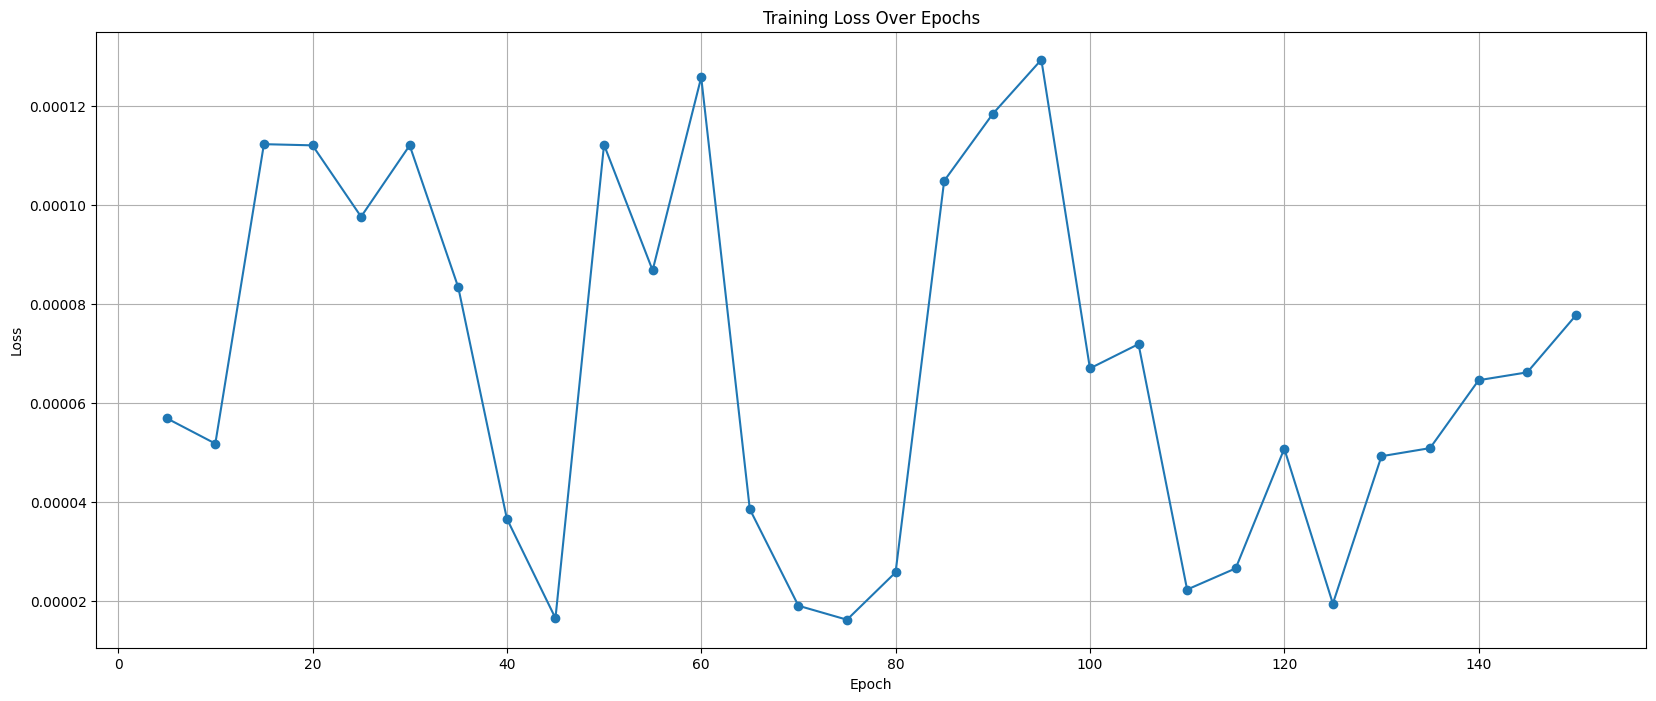

In [31]:
# Plot the loss values
plt.figure(figsize=(20, 8))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

**7) Evaluation**

In [32]:
# Evaluate the model
model.eval()
test_seq = Variable(test_seq)
with torch.no_grad():
    predicted = model(test_seq).cpu().numpy()
    predicted = price_scaler.inverse_transform(predicted)
    true = price_scaler.inverse_transform(test_target.cpu().numpy())

In [33]:
# Calculate regression metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(true, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true, predicted)
r2 = r2_score(true, predicted)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-squared (R^2): {r2:.4f}')

Mean Squared Error (MSE): 10.7306
Root Mean Squared Error (RMSE): 3.2758
Mean Absolute Error (MAE): 2.5379
R-squared (R^2): 0.9583


**7.1) ACCURACY for next day sell or buy**

In [34]:
# ACCURACY for next day sell or buy
real_acc_buy = []
pred_acc_buy = []
count = 0

for i in range(0, true.shape[0]-1):
  count = count + 1
  if true[i+1]-true[i] > 0:
    # Buy
    real_acc_buy.append(True)
  else:
    # Sell
    real_acc_buy.append(False)

  if predicted[i+1]-true[i] > 0:
    # Buy
    pred_acc_buy.append(True)
  else:
    # Sell
    pred_acc_buy.append(False)

right_pred = 0
for i in range(0, len(real_acc_buy)):
  if(real_acc_buy[i] == pred_acc_buy[i]):
      right_pred = right_pred+1

print(f'Accuracy : {round(right_pred/len(real_acc_buy)*100, 2)}%')

Accuracy : 55.32%


**8) Plot the True and the Predicted values**

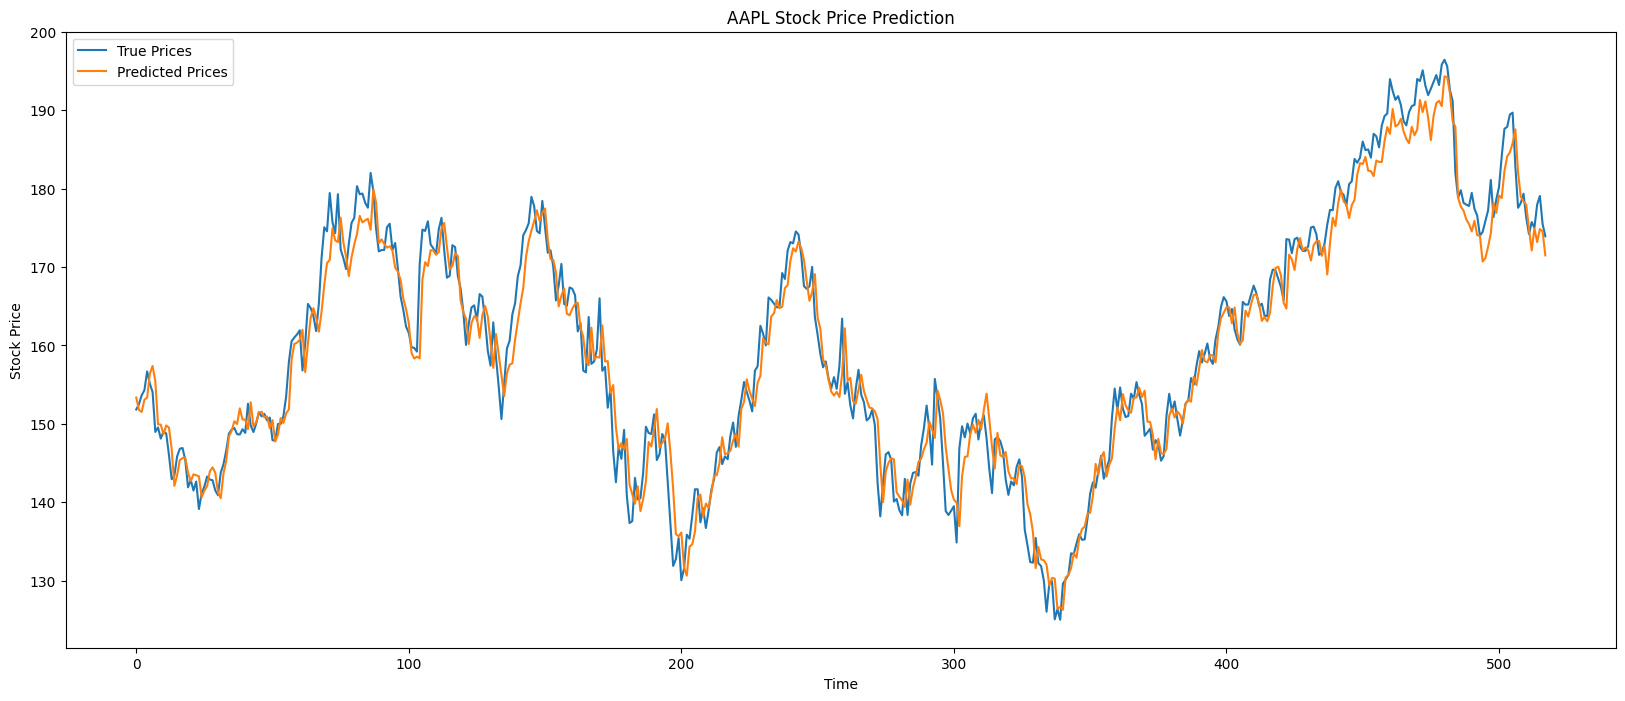

In [35]:
# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(true, label='True Prices')
plt.plot(predicted, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title(f'{symbol} Stock Price Prediction')
plt.show()

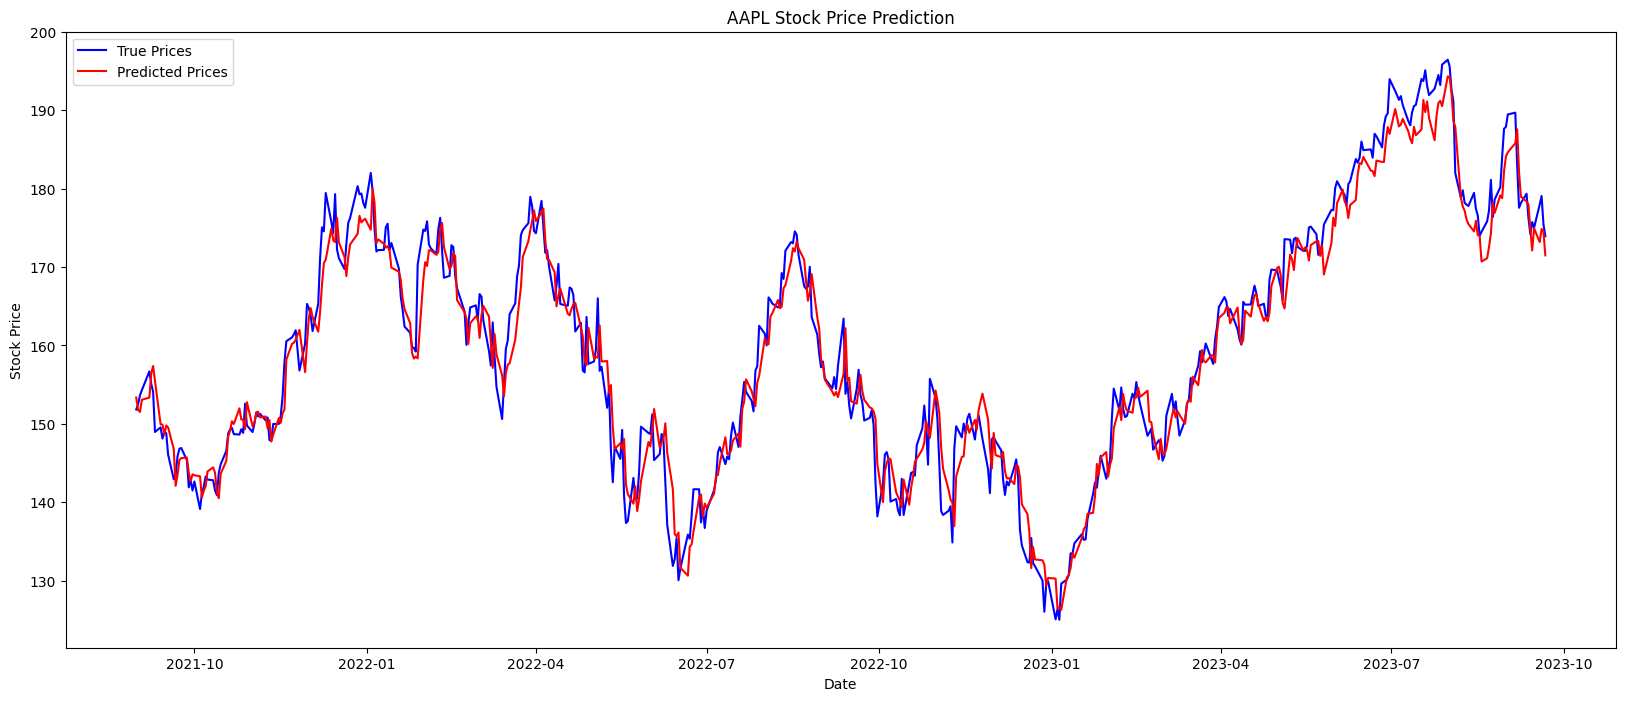

In [36]:
plt.figure(figsize=(20, 8))
plt.plot(data.index[-len(true):], true, label='True Prices', color='blue')
plt.plot(data.index[-len(predicted):], predicted, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title(f'{symbol} Stock Price Prediction')
plt.show()

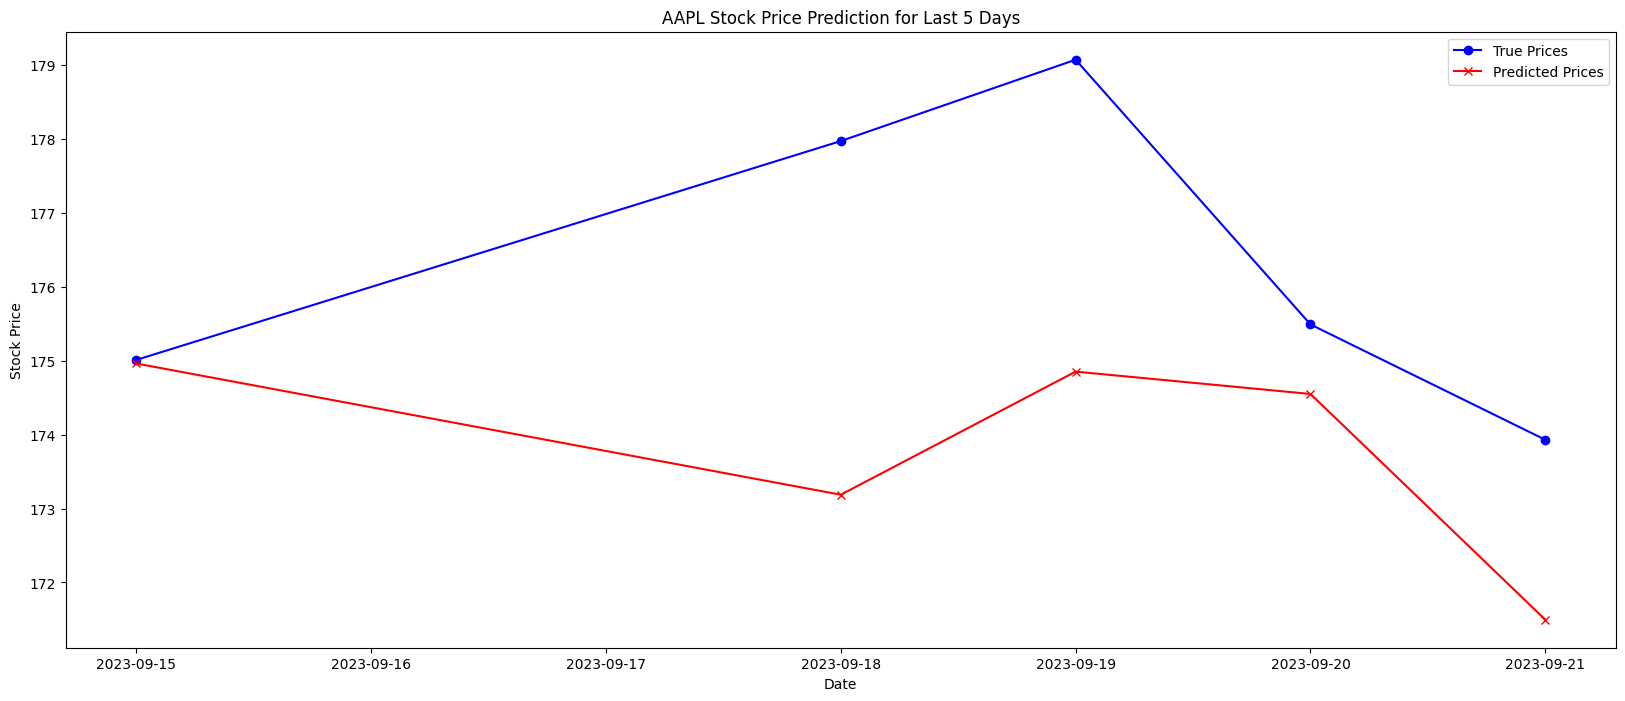

In [37]:
horizon = 5  # The sequence length as days to predict the next one
plt.figure(figsize=(20, 8))
plt.plot(data.index[-horizon:], true[-horizon:], label='True Prices', color='blue', marker='o')
plt.plot(data.index[-horizon:], predicted[-horizon:], label='Predicted Prices', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title(f'{symbol} Stock Price Prediction for Last {horizon} Days')
plt.show()

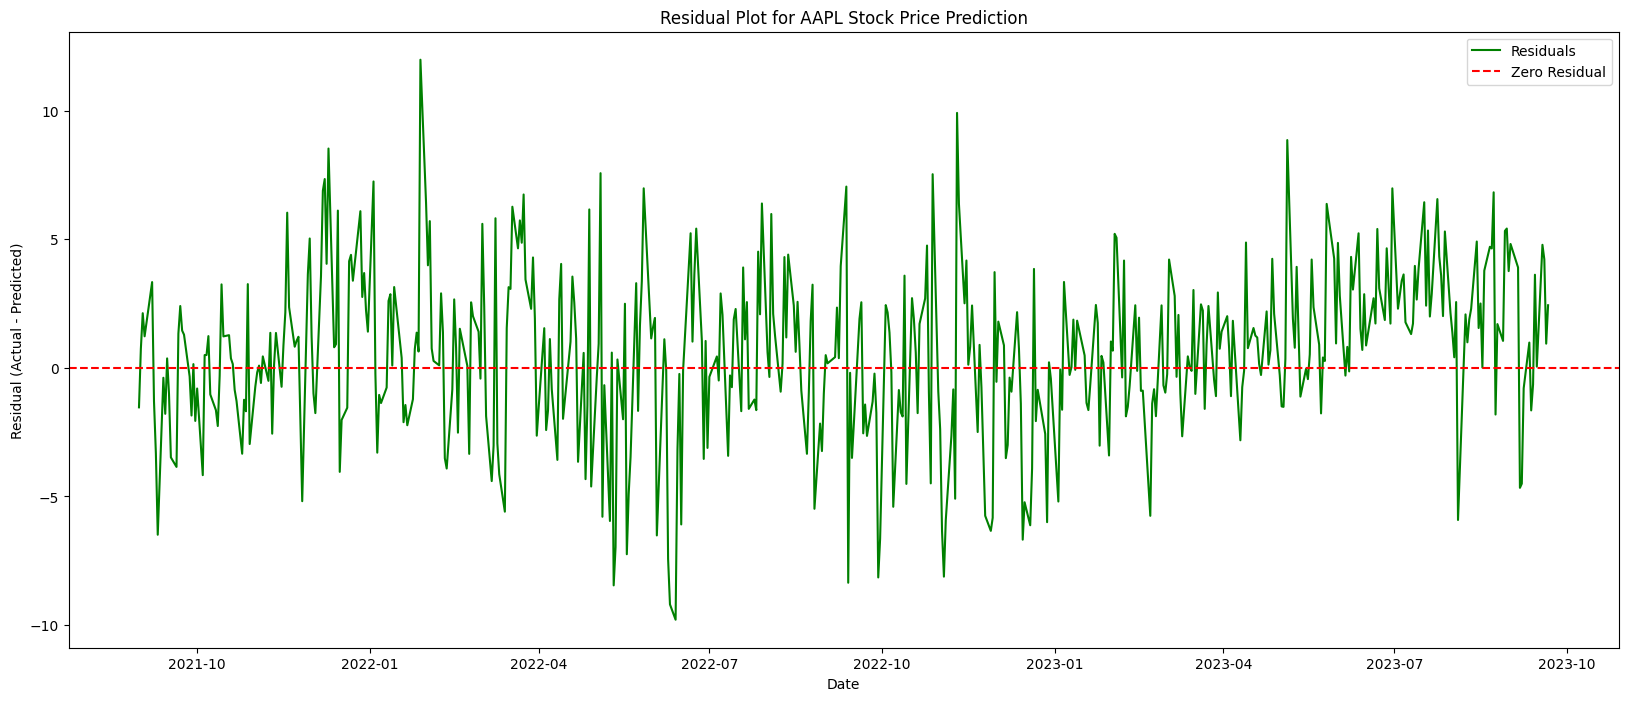

In [38]:
residuals = true - predicted
plt.figure(figsize=(20, 8))
plt.plot(data.index[-len(residuals):], residuals, label='Residuals', color='green')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend()
plt.title(f'Residual Plot for {symbol} Stock Price Prediction')
plt.show()

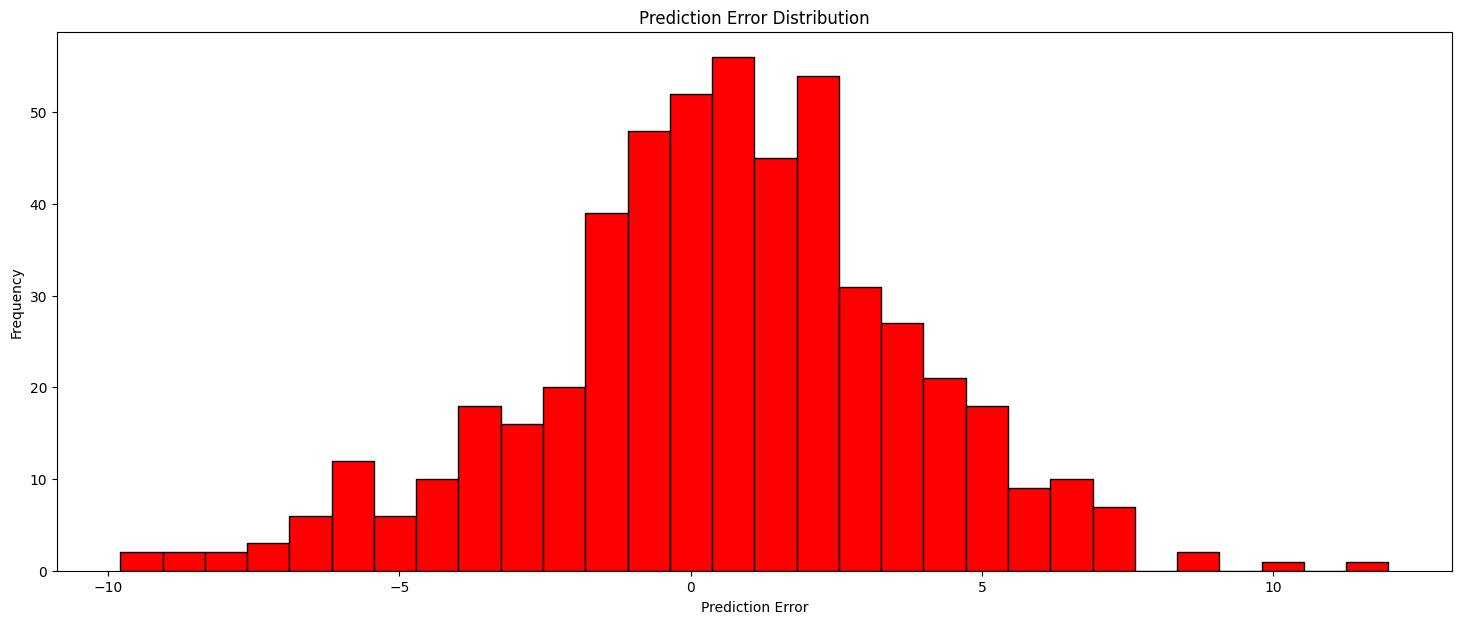

In [39]:
error = true - predicted
plt.figure(figsize=(18, 7))
plt.hist(error, bins=30, color='red', edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.show()

**9) Next day stock price prediction**

In [40]:
# Prepare data for the prediction
last_seq = data[["Close", "Volume", "RSI"]][-seq_length:]  # Use the last 'seq_length' data points
print(last_seq)

# Transform Close, Volume and RSI
price_transformed = price_scaler.transform(last_seq["Close"].values.reshape(-1, 1))
volume_transformed = vol_scaler.transform(last_seq["Volume"].values.reshape(-1, 1))
rsi_transformed = rsi_scaler.transform(last_seq["RSI"].values.reshape(-1, 1))

# Create the NumPy array with three components: price, volume and RSI
last_seq_normalized = np.concatenate((price_transformed, volume_transformed, rsi_transformed), axis=1)

# Add a dimension
last_seq_normalized = last_seq_normalized[np.newaxis, :, :]
last_seq_tensor = torch.from_numpy(last_seq_normalized).float().to(device)

print(last_seq_normalized.shape)

                 Close     Volume        RSI
Date                                        
2023-09-15  175.009995  109205100  44.451286
2023-09-18  177.970001   67257600  46.717917
2023-09-19  179.070007   51826900  41.852236
2023-09-20  175.490005   58436200  30.412405
2023-09-21  173.929993   63047900  28.474387
(1, 5, 3)


In [41]:
# Make the prediction for the next weekday date
with torch.no_grad():
    prediction = model(last_seq_tensor)
    prediction = price_scaler.inverse_transform(prediction.cpu().numpy())
    print(prediction[0][0])
    print(last_seq["Close"])
    print(data.index[-len(last_seq):])

171.4962
Date
2023-09-15    175.009995
2023-09-18    177.970001
2023-09-19    179.070007
2023-09-20    175.490005
2023-09-21    173.929993
Name: Close, dtype: float64
DatetimeIndex(['2023-09-15', '2023-09-18', '2023-09-19', '2023-09-20',
               '2023-09-21'],
              dtype='datetime64[ns]', name='Date', freq=None)


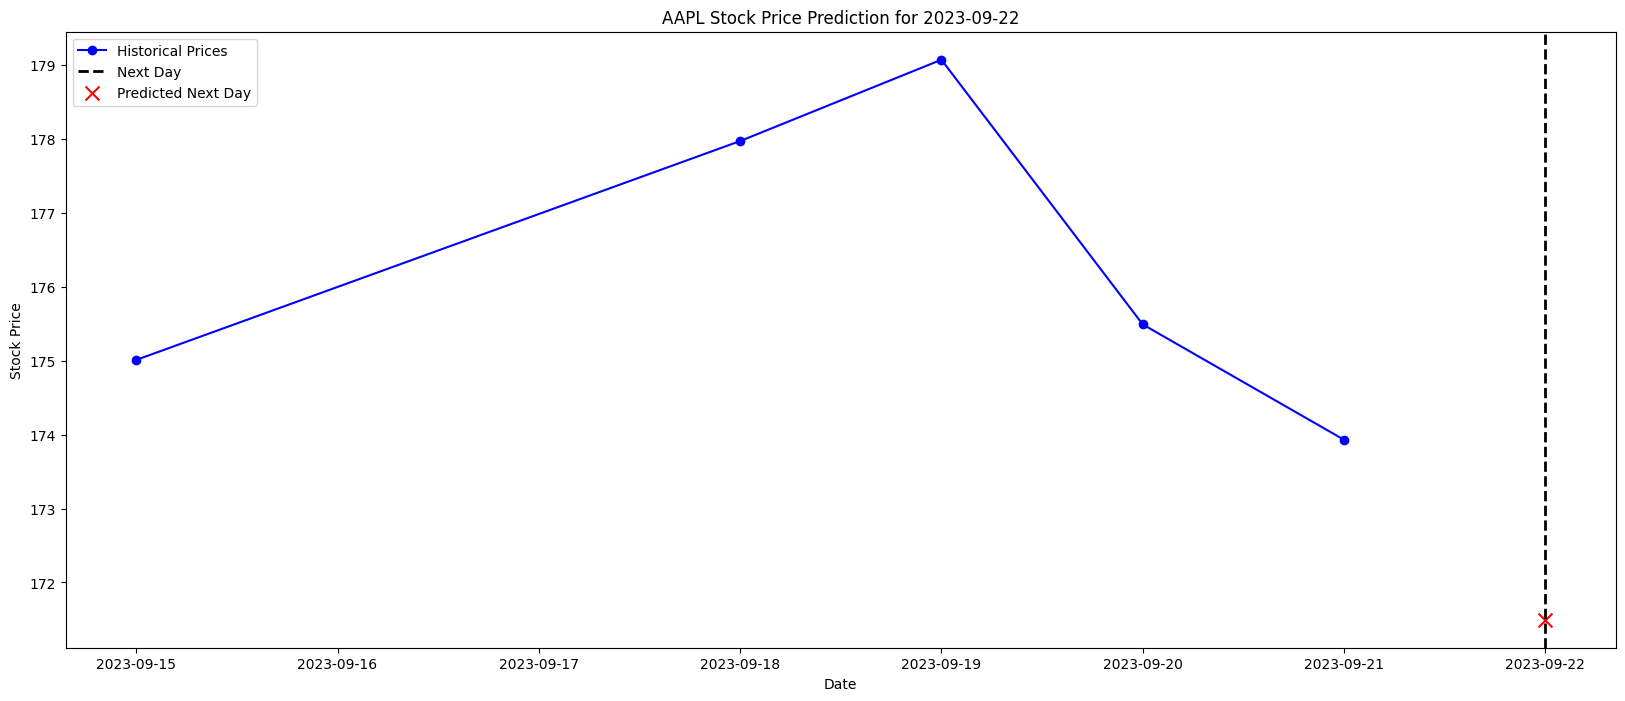

Predicted Closing Price for 2023-09-22: 171.49620056152344


In [42]:
# Plot historical prices and the predicted price for the next day
plt.figure(figsize=(20, 8))
plt.plot(data.index[-len(last_seq):], last_seq["Close"], label='Historical Prices', color='blue', marker='o')
plt.axvline(x=tomorrow_date, color='black', linestyle='--', label='Next Day', linewidth=2)
plt.scatter(tomorrow_date, prediction[0][0], color='red', marker='x', label='Predicted Next Day', s=100)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title(f'{symbol} Stock Price Prediction for {tomorrow_date.strftime("%Y-%m-%d")}')
plt.show()
# Print the predicted closing price for the next weekday
print(f"Predicted Closing Price for {tomorrow_date.strftime('%Y-%m-%d')}: {prediction[0][0]}")

In [43]:
import plotly.express as px
import plotly.graph_objects as go

# Create a DataFrame for visualization
data_vis = pd.DataFrame({'Date': data.index[-len(last_seq):], 'Price': last_seq["Close"]})
data_vis['Date'] = pd.to_datetime(data_vis['Date'])

# Create a Plotly line chart
fig = px.line(data_vis, x='Date', y='Price', title=f'{symbol} Stock Price Prediction for {tomorrow_date.strftime("%Y-%m-%d")}')

# Add a vertical line for the next day
fig.add_shape(
    dict(
        type="line",
        x0=tomorrow_date,
        x1=tomorrow_date,
        y0=0,
        y1=1,
        xref="x",
        yref="paper",
        line=dict(color="black", dash="dash"),
    )
)

# Add a scatter point for the predicted next day price
fig.add_trace(
    go.Scatter(
        x=[tomorrow_date],
        y=[prediction[0][0]],
        mode='markers',
        name="Predicted Next Day",
        marker=dict(color="red", size=10)
    )
)

fig.show()

# Print the predicted closing price for the next weekday
print(f"Predicted Closing Price for {tomorrow_date.strftime('%Y-%m-%d')}: {prediction[0][0]}")

Predicted Closing Price for 2023-09-22: 171.49620056152344


**9.1) For Tomorrow: "Sell or Buy"?**

In [44]:
import plotly.graph_objects as go

# Calculate the predicted next day closing price
predicted_next_day_price = prediction[0][0]

# Calculate the difference between the predicted next day and the current day closing prices
current_day_price = data_vis['Price'].iloc[-1]
price_difference = predicted_next_day_price - current_day_price

# Create a Plotly figure
fig = go.Figure()

# Add a trace for the stock price
fig.add_trace(go.Scatter(x=data_vis['Date'], y=data_vis['Price'], mode='lines', name='Stock Price'))

# Add a trace for the predicted next day price
fig.add_trace(go.Scatter(x=[tomorrow_date], y=[predicted_next_day_price],
                         mode='markers', name='Predicted Next Day Price',
                         marker=dict(color="red", size=10)))

# Create a text annotation for the predicted price
fig.add_annotation(
    x=tomorrow_date, y=predicted_next_day_price, text=f'Predicted: ${predicted_next_day_price:.2f}',
    showarrow=True, arrowhead=1, ax=0, ay=-30, font=dict(size=12, color='red')
)

# Create a text annotation for the current price
fig.add_annotation(
    x=data_vis['Date'].iloc[-1], y=current_day_price, text=f'Current: ${current_day_price:.2f}',
    showarrow=True, arrowhead=1, ax=0, ay=-30, font=dict(size=12)
)

# Add a vertical line for the next day
fig.add_shape(
    dict(
        type="line",
        x0=tomorrow_date,
        x1=tomorrow_date,
        y0=data_vis['Price'].min(),
        y1=data_vis['Price'].max(),
        xref="x",
        yref="y",
        line=dict(color="black", dash="dash"),
    )
)

# Update layout
fig.update_layout(
    title=f'{symbol} Stock Price Prediction for {tomorrow_date.strftime("%Y-%m-%d")}',
    xaxis_title='Date',
    yaxis_title='Price',
)

# Make a buy/sell recommendation based on the price difference
recommendation = "Buy" if price_difference > 0 else ("Sell" if price_difference < 0 else "Hold")
recommendation_color = "green" if recommendation == "Buy" else ("red" if recommendation == "Sell" else "black")

# Add a text annotation for the recommendation
fig.add_annotation(
    x=tomorrow_date, y=predicted_next_day_price - 10, text=f'Recommendation for tomorrow: {recommendation}',
    showarrow=False, font=dict(size=14, color=recommendation_color)
)

# Show the figure
fig.show()


**Save the model and weights**

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import os

# Define the parent directory path
parent_directory = '/content/drive/My Drive/my_models/'

# Create the directory if it doesn't exist
if not os.path.exists(parent_directory):
    os.makedirs(parent_directory)

In [47]:
# Save the model to the parent directory
torch.save(model.state_dict(), os.path.join(parent_directory, 'apple_pretrained_stock_forectasting_model.pth'))

In [48]:
from google.colab import files

# Provide the path to the model in your Google Drive
files.download(os.path.join(parent_directory, 'apple_pretrained_stock_forectasting_model.pth'))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>